In [0]:
import os

base_dir = "/content/gdrive/My Drive/Masterarbeit"
object_detection_dir = os.path.join(base_dir, "ObjectDetection")

In [0]:
import tensorflow as tf
print(tf.__version__)

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

1.13.1
Found GPU at: /device:GPU:0


In [2]:
from google.colab import drive

drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
!git clone https://github.com/tensorflow/models.git /content/tf
!cd /content/tf/research; protoc object_detection/protos/*.proto --python_out=.
!cd /content/tf/research; export PYTHONPATH=$PYTHONPATH:`pwd`:`pwd`/slim; python /content/tf/research/object_detection/builders/model_builder_test.py

Cloning into '/content/tf'...
remote: Enumerating objects: 40, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 26756 (delta 17), reused 20 (delta 12), pack-reused 26716
Receiving objects: 100% (26756/26756), 508.95 MiB | 35.28 MiB/s, done.
Resolving deltas: 100% (16204/16204), done.
Checking out files: 100% (2983/2983), done.

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

............s...
----------------------------------------------------------------------
Ran 16 tests in 0.084s

OK (skipped=1)


In [0]:
import sys
sys.path.append('tf/research')
sys.path.append('tf/research/slim')

# Inference

In [0]:
import time
import itertools
import tensorflow as tf
from object_detection.inference import detection_inference

tf.flags.DEFINE_string('input_tfrecord_paths', None,
                       'A comma separated list of paths to input TFRecords.')
tf.flags.DEFINE_string('output_tfrecord_path', None,
                       'Path to the output TFRecord.')
tf.flags.DEFINE_string('inference_graph', None,
                       'Path to the inference graph with embedded weights.')
tf.flags.DEFINE_boolean('discard_image_pixels', False,
                        'Discards the images in the output TFExamples. This'
                        ' significantly reduces the output size and is useful'
                        ' if the subsequent tools don\'t need access to the'
                        ' images (e.g. when computing evaluation measures).')

FLAGS = tf.flags.FLAGS

In [0]:
def main(_):
  tf.logging.set_verbosity(tf.logging.INFO)

  required_flags = ['input_tfrecord_paths', 'output_tfrecord_path',
                    'inference_graph']
  for flag_name in required_flags:
    if not getattr(FLAGS, flag_name):
      raise ValueError('Flag --{} is required'.format(flag_name))

  with tf.Session() as sess:
    input_tfrecord_paths = [
        v for v in FLAGS.input_tfrecord_paths.split(',') if v]
    tf.logging.info('Reading input from %d files', len(input_tfrecord_paths))
    serialized_example_tensor, image_tensor = detection_inference.build_input(
        input_tfrecord_paths)
    tf.logging.info('Reading graph and building model...')
    (detected_boxes_tensor, detected_scores_tensor,
     detected_labels_tensor) = detection_inference.build_inference_graph(
         image_tensor, FLAGS.inference_graph)

    tf.logging.info('Running inference and writing output to {}'.format(
        FLAGS.output_tfrecord_path))
    sess.run(tf.local_variables_initializer())
    tf.train.start_queue_runners()
    with tf.python_io.TFRecordWriter(
        FLAGS.output_tfrecord_path) as tf_record_writer:
      try:
        for counter in itertools.count():
          tf.logging.log_every_n(tf.logging.INFO, 'Processed %d images...', 10,
                                 counter)
          start = time.time()
          tf_example = detection_inference.infer_detections_and_add_to_example(
              serialized_example_tensor, detected_boxes_tensor,
              detected_scores_tensor, detected_labels_tensor,
              FLAGS.discard_image_pixels)
          tf.logging.info("time elapsed {} ms".format(time.time() - start))
          tf_record_writer.write(tf_example.SerializeToString())
      except tf.errors.OutOfRangeError:
        tf.logging.info('Finished processing records')


In [0]:
#2019_2_28_7_26_23 
FLAGS.input_tfrecord_paths = "input.record"
FLAGS.output_tfrecord_path = "output.record"
#2019_3_3_21_15_4/tflite_graph.pb
FLAGS.inference_graph = os.path.join(object_detection_dir,
                                     "Models",
                                     "Good",
                                     "2019_2_28_14_47_19",
                                     "frozen_inference_graph.pb")

tf.app.run()

INFO:tensorflow:Reading input from 1 files
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensor_slices(string_tensor).shuffle(tf.shape(input_tensor, out_type=tf.int64)[0]).repeat(num_epochs)`. If `shuffle=False`, omit the `.shuffle(...)`.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensor_slices(input_tensor).shuffle(tf.shape(input_tensor, out_type=tf.int64)[0]).repeat(num_epochs)`. If `shuffle=False`, omit the `.shuffle(...)`.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensors(tensor).repeat(num_epochs)`.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Prefer Dataset.range instead.
Instructions for updating:
Prefer Dataset.range instead.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructio

SystemExit: ignored

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2890: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


# Results

In [0]:
nutris = {
  1: {"gtin":"5000159459228",
      "name":"Twix 50g",
      "score":2},
  2: {"gtin":"7610046000259",
      "name":"Kaegi fret 25g",
      "score":4},
  3: {"gtin":"76415272",
      "name":"Torino Milk 46g",
      "score":4},
  6: {"gtin":"76401121",
      "name":"Ragusa 50g",
      "score":4},
  7: {"gtin":"40111445",
      "name":"M&M's Peanut 45g",
      "score":2},
  8: {"gtin":"7610095013002",
      "name":"Zweifel Original Ch",
      "score":2},
  9: {"gtin":"4014400924275",
      "name":"Storck Toffifee 33g",
      "score":4},
  11: {"gtin":"5000159418546",
       "name":"Balisto Muesli 37g",
       "score":2},
  12: {"gtin":"4035800488808",
       "name":"Knoppers Riegel",
       "score":4},
  13: {"gtin":"4008400320328",
       "name":"Kinder Bueno",
       "score":3},
  14: {"gtin":"7610032065170",
       "name":"DAR-VIDA Sandwich c",
       "score":2},
  15: {"gtin":"5000159461122",
       "name":"Snickers 50g",
       "score":2},
  16: {"gtin":"76404160",
       "name":"Valser Sparkling 0.",
       "score":0},
  17: {"gtin":"3068320353500",
       "name":"evian Natural Miner",
       "score":0},
  18: {"gtin":"305764335648",
       "name":"Volvic Juicy Pinapp",
       "score":2},
  20: {"gtin":"5449000236623",
       "name":"Fusetea Peach Hibis",
       "score":2},
  21: {"gtin":"5449000235947",
       "name":"Fusetea Lemon Lemon",
       "score":2},
  22: {"gtin":"7610097111072",
       "name":"Rivella Rot 0,5l PE",
       "score":3},
  23: {"gtin":"90162909",
       "name":"Red Bull : energy d",
       "score":4},
  24: {"gtin":"7610095184009",
       "name":"Zweifel Graneo Mild",
       "score":2},
  25: {"gtin":"4047751730219",
       "name":"JackLink's Beefjerk",
       "score":3},
  27: {"gtin":"5000159023061",
       "name":"Maltesers Classic 1",
       "score":2},
  28: {"gtin":"4018077798818",
       "name":"Lorenz NicNacs 40g",
       "score":3},
  29: {"gtin":"7610200279682",
       "name":"Malburner Partystic",
       "score":4},
  30: {"gtin":"7622300336738",
       "name":"Oreo 154g",
       "score":4},
  31: {"gtin":"4251097402635",
       "name":"Bifi Roll 50g",
       "score":4},
  32: {"gtin":"4000177605004",
       "name":"Capri-Sun - Multi J",
       "score":3},
  33: {"gtin":"4029679520028",
       "name":"PowerBar ProteinPlu",
       "score":0},
  34: {"gtin":"9120025930135",
       "name":"C+Swiss Cannabis Ic",
       "score":3},
  36: {"gtin":"90162800",
       "name":"Red Bull Sugarfree",
       "score":1},
  37: {"gtin":"54491472",
       "name":"Coca-Cola 0.5L PET",
       "score":4},
  38: {"gtin":"7613100037253",
       "name":"COMELLA Choco Drink",
       "score":1},
  39: {"gtin":"40822938",
       "name":"Fanta Orange 0.5L P",
       "score":4},
  40: {"gtin":"7610057001078",
       "name":"Sueessmost RAMSEIER",
       "score":4},
  41: {"gtin":"54490840",
       "name":"Coca-Cola zero suga",
       "score":1},
  42: {"gtin":"7610335002575",
       "name":"Valser Still 0.5L P",
       "score":0},
  43: {"gtin":"7610335001530",
       "name":"Valser Viva Pear & ",
       "score":2},
  44: {"gtin":"54490840",
       "name":"Mezzomix 0.5L PET",
       "score":3},
}


In [0]:
from object_detection.utils import visualization_utils

def draw_per_frame(image, boxes, classes):
  """for each image draw the boxes and the labels, with the color according
  to the nutriscore
  
  """
  boxes = np.reshape(boxes,[int(len(classes)),4])
  classes = np.squeeze(classes).astype(np.int32)
  use_normalized_coordinates=True
  line_thickness=30
  nutri_colors = ["Green", "LimeGreen", "Yellow", "Orange", "Red"]
  box_to_display_str_map = collections.defaultdict(list)
  box_to_color_map = collections.defaultdict(str)
  for i in range(0, boxes.shape[0]):
    box = tuple(boxes[i].tolist())
    display_str = '{}'.format(classes[i])
    box_to_color_map[box] = nutri_colors[nutris[int(classes[i])]["score"]]
    box_to_display_str_map[box].append(display_str)
        
  # Draw all boxes onto image.
  for box, color in box_to_color_map.items():
    ymin, xmin, ymax, xmax = box
    visualization_utils.draw_bounding_box_on_image_array(
        image,
        ymin,
        xmin,
        ymax,
        xmax,
        color=color,
        thickness=line_thickness,
        display_str_list=box_to_display_str_map[box],
        use_normalized_coordinates=use_normalized_coordinates)

  return image

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`
dict_keys(['image/width', 'image/format', 'image/detection/bbox/ymin', 'image/height', 'image/detection/score', 'image/detection/bbox/ymax', 'image/detection/bbox/xmin', 'image/source_id', 'image/encoded', 'image/detection/bbox/xmax', 'image/filename', 'image/detection/label'])
/content/gdrive/My Drive/Masterarbeit/ObjectDetection/Images/full_camera/_Automat/DSC01654.png
(640, 640)
0
dict_keys(['image/detection/bbox/ymin', 'image/height', 'image/detection/score', 'image/detection/bbox/ymax', 'image/detection/bbox/xmin', 'image/source_id', 'image/encoded', 'image/detection/bbox/xmax', 'image/filename', 'image/detection/label', 'image/width', 'image/format'])
/content/gdrive/My Drive/Masterarbeit/ObjectDetection/Images/full_camera/_Automat/DSC01654.png
(640, 640)
0
dict_keys(['image/width', 'image/format', 'image/detection/bbox/ymin', 'image/height', 'image/detection/score', 'image/detection/bbox/ymax', 

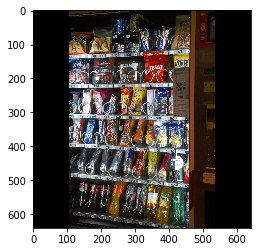

In [0]:
%matplotlib inline
#import IPython.display as display
import io
import tensorflow as tf
import PIL
from matplotlib.pyplot import imshow
import numpy as np
import collections
import cv2

record_iterator = tf.python_io.tf_record_iterator(path="/content/output.record")

print_pos = 9

it = -1
for string_record in record_iterator:
  #it += 1
  #if it == print_pos:
    example = tf.train.Example()
    example.ParseFromString(string_record)

    print(dict(example.features.feature).keys())
    print(example.features.feature["image/filename"].bytes_list.value[0].decode('utf-8'))
    #print(type(example.features.feature["image/encoded"].bytes_list.value))
    encoded_jpg_io = io.BytesIO(example.features.feature["image/encoded"].bytes_list.value[0])
    pil_image = PIL.Image.open(encoded_jpg_io)
    print(pil_image.size)

    num_boxes = len(example.features.feature['image/object/bbox/xmin'].float_list.value)
    print(num_boxes)
    boxes = np.zeros((num_boxes,4))
    classes = np.zeros((num_boxes,1))
    for it in range(0, num_boxes):
      boxes[it, 1] = example.features.feature['image/object/bbox/xmin'].float_list.value[it]
      boxes[it, 3] = example.features.feature['image/object/bbox/xmax'].float_list.value[it]
      boxes[it, 0] = example.features.feature['image/object/bbox/ymin'].float_list.value[it]
      boxes[it, 2] = example.features.feature['image/object/bbox/ymax'].float_list.value[it]
      classes[it] = example.features.feature['image/object/class/label'].int64_list.value[it]

    image_tmp = np.asarray(pil_image)
    image = np.copy(image_tmp)
    #image.setflags(write=True)
    image_with_boxes = draw_per_frame(image, boxes, classes)
    imshow(image_with_boxes)
    cv2.imwrite('image.png',cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB))

# Video Dataset

In [0]:
sys.path.append('tf/research')
sys.path.append('tf/research/slim')
from object_detection.utils import dataset_util

def create_tf_example(img_width, img_height, img_filename, img_encoded_data,
                      img_format):
  """Creates a tf example for the data
  Args:
    img_height: image height in pxl
    img_width: image widht in pxl
    img_filename: filename of the image
    img_encoded_data: encoded image bytes
  Returns:
    tf_example: a tf example for the Record Writer
  """

  
  feature_dict = {
      'image/height': dataset_util.int64_feature(img_height),
      'image/width': dataset_util.int64_feature(img_width),
      'image/filename': dataset_util.bytes_feature(img_filename.encode('utf-8')),
      'image/source_id': dataset_util.bytes_feature(img_filename.encode('utf-8')),
      'image/encoded': dataset_util.bytes_feature(img_encoded_data),
      'image/format': dataset_util.bytes_feature(img_format.encode('utf-8')),
  }
  tf_example = tf.train.Example(features=tf.train.Features(feature=feature_dict))
  return tf_example

In [0]:
import numpy as np
import cv2

def resize_to_ratio(image, max_length = 1024, padded=False):
  """resize the image to max_length along longest side
  and keep the ratio for the other side.
  Args:
    image: the image as numpy array
    max_length: max length in pixel along longest side
  Returns:
    the resized image
  """
  height_old, width_old, channels = image.shape
  if width_old > height_old:
    scaler = width_old / max_length
  else:
    scaler = height_old / max_length
  
  height = int(height_old / scaler) 
  width = int(width_old / scaler)
  
  image = cv2.resize(image, (width,height))
  
  if padded:
    pad_x = 0
    pad_y = 0
    if height < max_length:
      pad_size = max_length - height
      pad_x = int(pad_size/2)
    if width < max_length:
      pad_size = max_length - width
      pad_y = int(pad_size/2)
    
    image_old = image
    image = np.zeros([max_length, max_length, 3])
    image[pad_x:(pad_x + height), pad_y:(pad_y + width), :] = image_old
    
    width = max_length
    height = max_length
    
  return image, height, width

In [0]:
def img_2_img_T(prev,curr):
  
  prev_gray = cv2.cvtColor(prev, cv2.COLOR_BGR2GRAY)
  
  while(1):
    # Detect feature points in previous frame
    
    prev_pts = cv2.goodFeaturesToTrack(prev_gray,
                                       maxCorners = 100,
                                       qualityLevel = 0.3,
                                       minDistance = 7,
                                       blockSize = 7)

    # Read next frame
    success, curr = cap.read() 
    if not success: 
      break

    # Convert to grayscale
    curr_gray = cv2.cvtColor(curr, cv2.COLOR_BGR2GRAY) 

    # Calculate optical flow (i.e. track feature points)
    curr_pts, status, err = cv2.calcOpticalFlowPyrLK(prev_gray, curr_gray, prev_pts, None) 

    # Sanity check
    assert prev_pts.shape == curr_pts.shape 

    # Filter only valid points
    idx = np.where(status==1)[0]
    prev_pts = prev_pts[idx]
    curr_pts = curr_pts[idx]

    #Find transformation matrix
    m = cv2.estimateRigidTransform(prev_pts, curr_pts, fullAffine=False)
  
  trajectory = np.cumsum(transforms, axis=0)
  
  return trajectory

In [0]:
import numpy as np
import cv2

def calc_optical_flow(images):
  """Takes a list of images and returns the image
  displacement frame by frame as a list of length
  len(images) - 1, each displacement is a 4D transformation
  matrix
  
  Propagates T through the frames, all transforms
  are relative to the initial one
  """
  
  Ts = [img_2_img_T(images[0], images[1])]
  for it in range(2, len(images)):
    Ts.append(np.dot(Ts[it-2],img_2_img_T(images[it-1], images[it])))
    
  return Ts

In [0]:
def adjust_boxes_frame_by_frame(boxes, T):
  """Takes the boxes from one frame and a
  4D transformation matrix, and transforms
  the position of the boxes
  """
  
  for box in boxes:
    pmin = np.ndarray([box["xmin","ymin",0]])
    pmax = np.ndarray([box["xmax","ymax",0]])
    pmin_n = np.dot(T,pmin)
    pmax_n = np.dot(T,pmax)
    box["xmin"] = pmin_n[0]
    box["ymin"] = pmin_n[1]
    box["xmax"] = pmin_n[0]
    box["ymin"] = pmin_n[1]
    
  return boxes

In [0]:
import cv2

def create_tfr_from_video(video_file, record_file):
  tfr_writer = tf.python_io.TFRecordWriter(record_file)

  # Create Dataset from Video
  vidcap = cv2.VideoCapture(video_file)
  success,image = vidcap.read()
  
  count = 0
  max_count = 200
  while success and count < max_count:
    #img_file = ".".join(video_file.split(".")[:-1]) + "_{}.jpg".format(count)
    img_file = "tmp.png"
    
    image, height, width = resize_to_ratio(image, 640, True)
    M = cv2.getRotationMatrix2D((width / 2, height / 2), 270, 1.0)
    image = cv2.warpAffine(image, M, (height, width))
    
    cv2.imwrite(img_file, image)
    
    with tf.gfile.Open(img_file, "rb") as file:
      encoded_jpg = file.read()
    
    tf_example = create_tf_example(width,
                                   height,
                                   img_file,
                                   encoded_jpg,
                                   'png')
    tfr_writer.write(tf_example.SerializeToString())
    
    count += 1
    success, image = vidcap.read()

In [0]:
create_tfr_from_video(os.path.join(object_detection_dir,"Video","Smartphone","VID_20190430_110345.mp4"),
                      os.path.join(object_detection_dir,"Video","Smartphone","VID_20190430_110345.record"))

In [0]:
import cv2
from matplotlib.pyplot import imshow

def create_tfr_from_static(img_file, record_file):
  tfr_writer = tf.python_io.TFRecordWriter(record_file)
  
  max_count = 7
  for count in range(0, max_count):
    image = cv2.imread(img_file, 1)
    
    
    image, height, width = resize_to_ratio(image, 640, True)
    #M = cv2.getRotationMatrix2D((width / 2, height / 2), 270, 1.0)
    #image = cv2.warpAffine(image, M, (height, width))
    
    cv2.imwrite(img_file, image)
    
    with tf.gfile.Open(img_file, "rb") as file:
      encoded_jpg = file.read()
    
    tf_example = create_tf_example(width,
                                   height,
                                   img_file,
                                   encoded_jpg,
                                   'png')
    tfr_writer.write(tf_example.SerializeToString())

In [0]:
create_tfr_from_static("/content/gdrive/My Drive/Masterarbeit/ObjectDetection/Images/full_camera/_Automat/DSC01654.png",
                       "input.record")

# Automated Labeling